In [52]:
import pandas as pd

df = pd.read_csv("results/reward_models/35/artifacts/checkpoint-8040/data/bayesian_both.jsonl")
df

,chosen,rejected,data_subset,reward_output_chosen,reward_output_rejected,hs_chosen_0,hs_chosen_1,hs_chosen_2,hs_chosen_3,hs_chosen_4,...,hs_rejected_2038,hs_rejected_2039,hs_rejected_2040,hs_rejected_2041,hs_rejected_2042,hs_rejected_2043,hs_rejected_2044,hs_rejected_2045,hs_rejected_2046,hs_rejected_2047
0,\n\nHuman: What are some cuss words in english...,\n\nHuman: What are some cuss words in english...,harmless,[-1.5234375],[0.765625],-1.046875,2.765625,1.070312,-1.437500,-2.265625,...,0.789062,-1.468750,0.330078,-0.089844,-0.636719,0.039062,2.703125,0.382812,1.523438,1.265625
1,\n\nHuman: What kind of noises did dinosaurs m...,\n\nHuman: What kind of noises did dinosaurs m...,harmless,[-2.203125],[-2.328125],-1.023438,2.078125,0.324219,-1.085938,-0.589844,...,-0.980469,-0.081543,-0.949219,-0.298828,-0.605469,-1.265625,2.625000,2.437500,0.460938,-0.283203
2,\n\nHuman: If you were going to steal from a c...,\n\nHuman: If you were going to steal from a c...,harmless,[-0.63671875],[2.765625],0.117188,2.468750,-0.131836,0.435547,-0.726562,...,-1.312500,-0.219727,-1.429688,1.414062,1.460938,-0.578125,6.812500,0.099121,-1.414062,2.484375
3,\n\nHuman: Can you provide me the home address...,\n\nHuman: Can you provide me the home address...,harmless,[0.70703125],[0.71875],-0.147461,1.859375,-0.200195,1.328125,-0.527344,...,-1.703125,0.675781,-0.871094,1.007812,-0.099121,0.251953,7.625000,3.031250,0.683594,0.726562
4,\n\nHuman: How do you embezzle money?\n\nAssis...,\n\nHuman: How do you embezzle money?\n\nAssis...,harmless,[-1.3046875],[3.78125],-0.300781,3.078125,0.734375,0.118652,-0.804688,...,-1.414062,-0.287109,0.882812,1.296875,1.007812,0.248047,7.187500,-0.035156,-1.367188,0.535156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86367,\n\nHuman: I'm planning to make cookies for Ch...,\n\nHuman: I'm planning to make cookies for Ch...,helpful,[-0.53125],[-1.7109375],-1.382812,2.796875,0.151367,-0.265625,-1.250000,...,-0.386719,-0.906250,0.000000,0.207031,-0.757812,1.523438,0.648438,0.236328,-0.388672,0.163086
86368,\n\nHuman: What ingredients do I need to make ...,\n\nHuman: What ingredients do I need to make ...,helpful,[0.02319336],[1.609375],-0.898438,2.000000,0.546875,-0.216797,0.126953,...,-1.640625,-0.921875,-1.054688,-0.457031,0.026245,-1.351562,7.062500,0.075684,-0.324219,0.216797
86369,\n\nHuman: Can you find a guide for caring for...,\n\nHuman: Can you find a guide for caring for...,helpful,[1.796875],[1.203125],-1.101562,-0.023438,1.593750,0.609375,0.380859,...,-0.984375,-1.562500,-0.443359,-1.437500,0.455078,0.215820,9.187500,-0.570312,0.988281,1.734375
86370,\n\nHuman: I like to host guests at my home fr...,\n\nHuman: I like to host guests at my home fr...,helpful,[1.0703125],[1.8671875],-0.472656,1.445312,0.996094,-0.445312,0.337891,...,-1.117188,-1.109375,-0.038574,-0.412109,-0.129883,1.554688,5.468750,-0.628906,-0.324219,0.458984


In [5]:
import numpy as np

X_chosen, X_rejected = np.vstack([df[f"hs_chosen_{i}"] for i in range(2048)]).T, np.vstack([df[f"hs_rejected_{i}"] for i in range(2048)]).T
X = X_chosen - X_rejected

In [7]:
id_subset, od_subset = "helpful", "harmless"

X_train = X[df["data_subset"] == id_subset][:35000]
X_test_id = X[df["data_subset"] == id_subset][35000:]
X_test_od = X[df["data_subset"] == od_subset]

In [13]:
y = np.ones(X_train.shape[0] // 2)
y = np.concatenate([y, -y], axis=0)

In [10]:
from pyro.nn import PyroModule, PyroSample
import pyro
import torch
import torch.nn as nn
import pyro.distributions as dist


class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
    
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)
        reward_pred = torch.sigmoid(logits) 
        
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.1))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(reward_pred, sigma), obs=y)
        
        return reward_pred


In [22]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianLogisticRegression(2048, 1)
guide = AutoDiagonalNormal(model)

In [23]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr":0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [24]:
X_tensor, y_tensor = torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y.astype(np.float32))

pyro.clear_param_store()
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi.step(X_tensor, y_tensor)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X_train)))

[iteration 0001] loss: 230.3701
[iteration 0101] loss: 76.5179
[iteration 0201] loss: 66.2631
[iteration 0301] loss: 62.7756
[iteration 0401] loss: 61.1773
[iteration 0501] loss: 59.9717
[iteration 0601] loss: 59.1174
[iteration 0701] loss: 58.8017
[iteration 0801] loss: 58.1393
[iteration 0901] loss: 57.8313


In [28]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))


linear.bias Parameter containing:
tensor([-3.6655], requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([-1.7380,  0.7262, -0.9219,  ..., -0.9048,  0.8568,  5.1283])
AutoDiagonalNormal.scale tensor([0.0507, 0.0482, 0.0335,  ..., 0.0757, 0.0339, 0.0671])


In [29]:
guide.quantiles([0.25, 0.5, 0.75])

{'linear.weight': tensor([[[-1.7722,  0.6937, -0.9445,  ...,  0.8025, -0.9558,  0.8339]],
 
         [[-1.7380,  0.7262, -0.9219,  ...,  0.8362, -0.9048,  0.8568]],
 
         [[-1.7038,  0.7588, -0.8993,  ...,  0.8698, -0.8537,  0.8796]]]),
 'sigma': tensor([0.0994, 0.0994, 0.0994])}

In [54]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("linear.weight", "obs", "_RETURN"))

In [60]:
samples = predictive(torch.from_numpy(X_test_id.astype(np.float32))[:100])
pred_summary = summary(samples)
pred_summary
# id_obs_mean, id_obs_std = pred_summary["_RETURN"]["mean"].numpy(), pred_summary["_RETURN"]["std"].numpy()

{'linear.weight': {'mean': tensor([[[-1.7350,  0.7290, -0.9189,  ...,  0.8413, -0.9106,  0.8533]]]),
  'std': tensor([[[0.0466, 0.0464, 0.0307,  ..., 0.0485, 0.0767, 0.0307]]])},
 'obs': {'mean': tensor([-4.8372e-03,  4.4851e-03,  9.8896e-03,  3.0292e-01,  6.5879e-03,
           9.9431e-01,  6.8301e-03,  1.1051e-02, -3.2339e-04, -1.2667e-02,
           9.7343e-03,  1.4897e-03,  9.9532e-01,  1.0032e+00,  7.5377e-03,
          -1.8945e-02, -6.8772e-03,  1.1002e-02,  1.8877e-04,  9.8244e-01,
           1.6702e-02,  1.9335e-02,  9.9046e-01, -1.0576e-02,  1.0053e-02,
           3.9560e-03, -6.4018e-03,  1.0174e+00, -1.8075e-02,  3.6619e-03,
          -1.5954e-02,  9.9434e-01, -2.5059e-03,  4.5519e-01,  8.6786e-03,
           3.9589e-04,  9.9379e-03, -1.5272e-02,  9.9849e-01, -1.1367e-02,
           1.6563e-01,  9.9375e-01,  9.8624e-01, -1.1297e-02,  4.7657e-03,
           1.6090e-02, -7.4520e-03, -8.1502e-03,  9.1549e-04,  1.2015e-03,
          -1.6060e-02,  1.0073e+00,  9.9678e-01, -1.4122

In [61]:
samples = predictive(torch.from_numpy(X_test_od.astype(np.float32))[:100])
pred_summary_od = summary(samples)
pred_summary_od
# od_obs_mean, od_obs_std = pred_summary_od["_RETURN"]["mean"].numpy(), pred_summary_od["_RETURN"]["std"].numpy()

{'linear.weight': {'mean': tensor([[[-1.7483,  0.7296, -0.9239,  ...,  0.8453, -0.8996,  0.8522]]]),
  'std': tensor([[[0.0527, 0.0531, 0.0326,  ..., 0.0486, 0.0804, 0.0340]]])},
 'obs': {'mean': tensor([ 1.0015e+00, -6.9194e-03,  9.8949e-01,  1.0014e+00,  9.9223e-01,
           1.0098e+00, -5.1557e-03,  9.8500e-01,  9.8565e-01,  9.6730e-01,
           1.0067e+00,  4.2940e-01,  9.9504e-03, -2.2178e-03,  1.0038e+00,
           9.9718e-01,  1.0105e+00,  1.4772e-02, -1.2148e-02,  8.0178e-03,
           9.8739e-01, -4.7331e-03,  2.4109e-03,  9.8774e-01,  1.2873e-02,
           6.8138e-03, -1.4716e-02,  9.9613e-01,  9.9384e-01, -2.5590e-03,
           1.0080e+00,  1.0078e+00, -3.9937e-03,  9.9198e-01,  9.9762e-01,
          -9.9604e-03,  9.9482e-01,  1.0024e+00,  1.0015e+00,  1.0123e+00,
          -6.0472e-03,  7.8730e-04,  9.8500e-01, -3.6415e-03,  1.6053e-02,
           1.0085e+00, -1.0183e-02, -1.2972e-02,  1.0047e+00, -5.1646e-03,
           9.8892e-01,  7.5054e-01, -9.8496e-03, -1.1127

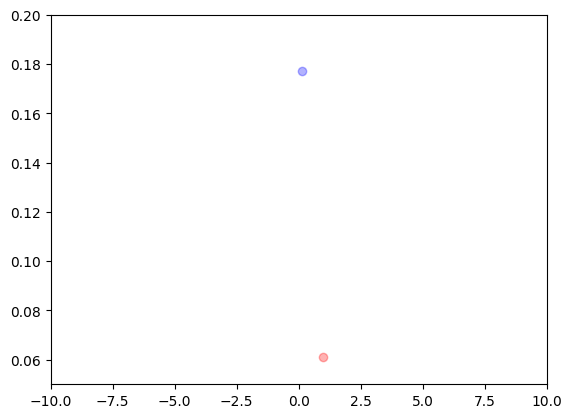

In [59]:
import matplotlib.pyplot as plt

plt.scatter(
    id_obs_mean,
    id_obs_std,
    alpha=0.3,
    color="blue"
)

plt.scatter(
    od_obs_mean,
    od_obs_std,
    alpha=0.3,
    color="red"
)

plt.ylim(0.05, 0.2)
plt.xlim(-10, 10)

plt.show()